# Libraries

In [3]:
!pip install kneed

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 7.0)
import PIL.Image as Image
from sklearn.cluster import KMeans
from kneed import KneeLocator

## K-Means

### Test Data

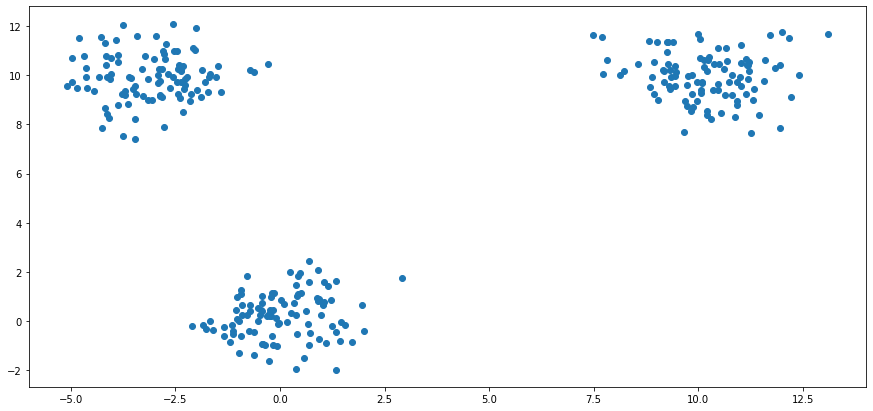

In [5]:
mean1 = [0, 0]
mean2 = [10, 10]
mean3 = [-3, 10]
cov = [[1,0], [0,1]]
x1 = np.random.multivariate_normal(mean1, cov, 100)
x2 = np.random.multivariate_normal(mean2, cov, 100)
x3 = np.random.multivariate_normal(mean3, cov, 100)
x = np.concatenate([x1,x2,x3])

plt.scatter(x[:,0], x[:,1])

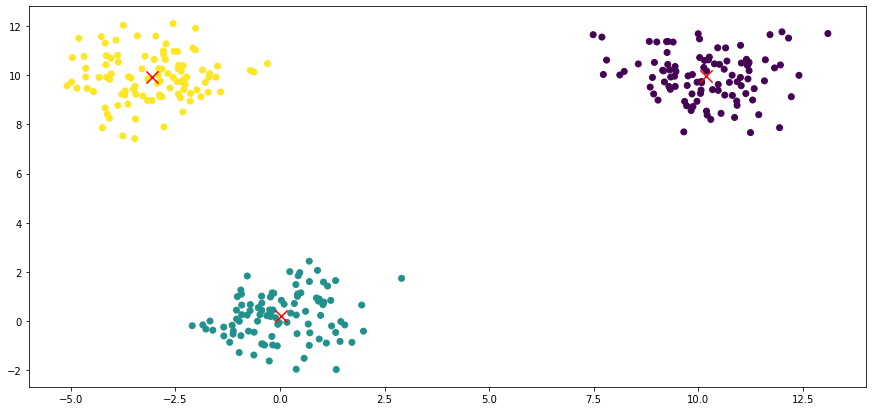

In [6]:
model = KMeans(n_clusters=3).fit(x)
labels = model.labels_
centers = model.cluster_centers_
plt.scatter(x[:,0], x[:,1], c = labels)
plt.scatter(centers[:,0], centers[:,1], color = 'red', marker='x', s = 150)

## Image Data

Loading Image

img = Image.open('bird.png')
basewidth = 300
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('yellow_bird.jpg') 

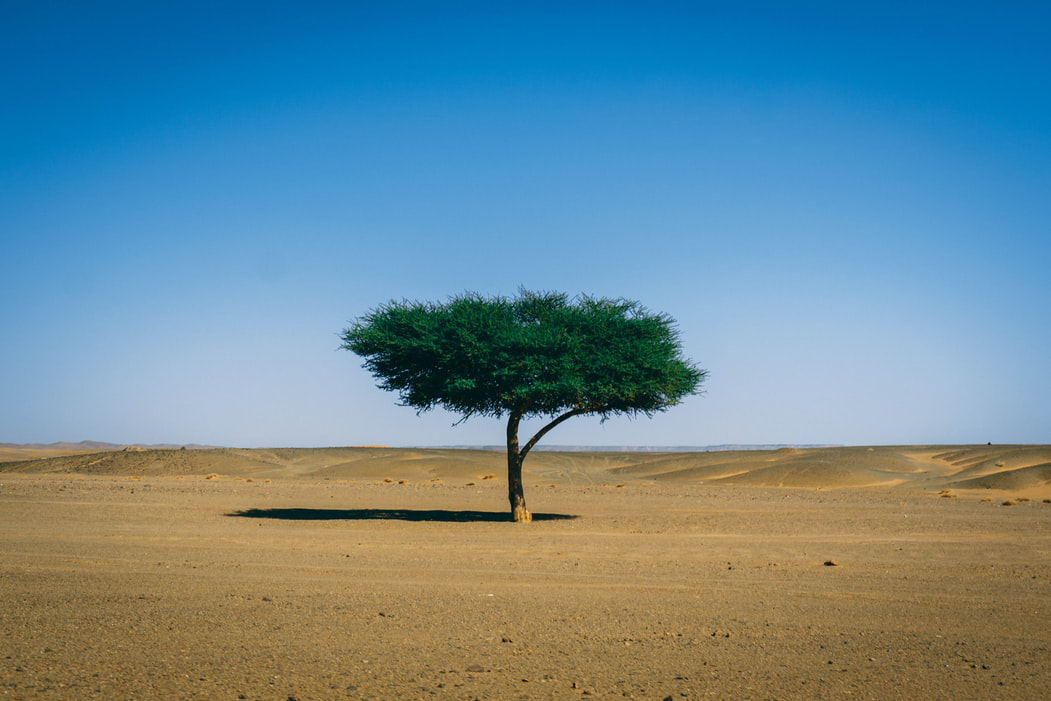

In [11]:
img = Image.open('tree_desert_free.jpg')
img  # or, if you're not using a jupyter notebook, use display(img) 

Stacking Pixels

In [12]:
img = img.convert('RGB') # To make the image has been read in the RGB space 
width, height = img.size # Keep track of the initial dimensions
img_array = np.array(img) # to numpy array
img_stack = img_array.reshape(-1,3) # stacks pixels

### Image Segmentation

Deciding on the number of clusters

3
4
5
6
7
8
9


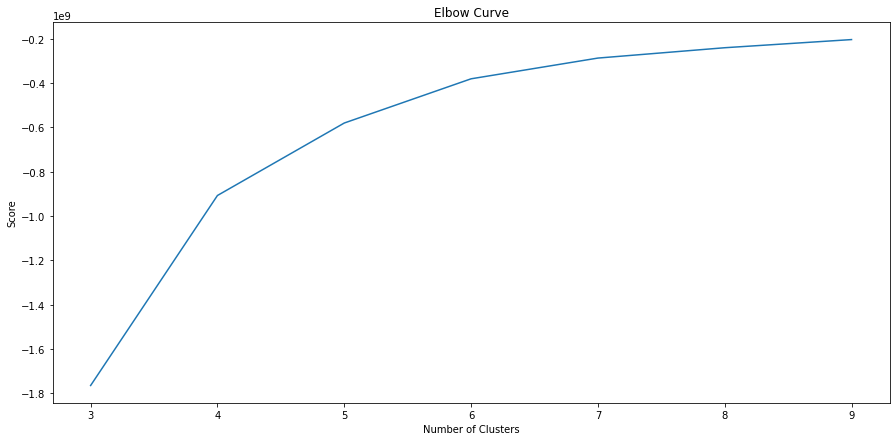

In [13]:
Nc = range(3, 10)
kmeans_scores = []
for c in Nc:
  print(c)
  kmeans_scores.append(KMeans(n_clusters=c).fit(img_stack).score(img_stack))
#kmeans_scores = [ for i in Nc]
plt.plot(Nc,kmeans_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [14]:
kneedle = KneeLocator(Nc, kmeans_scores, S=1.0, curve="concave", direction="increasing")
C = kneedle.knee
C

5

Re-running the algorithm using the selected number of clusters

In [15]:
img_model = KMeans(n_clusters=C)
img_model.fit(img_stack)
labels = img_model.labels_
centers = img_model.cluster_centers_

Reconstructing Image

In [16]:
def map_color(img_stack, labels, keep_labels=list()):
    """
    Calculates the mean color of all pixels in the same cluster and assigns the pixels to their cluster's color.
    """
    mean_colors = {}
    all_clusters = np.unique(labels)
    if keep_labels:
      return np.array([pixel if labels[i] in keep_labels else np.array([255, 255, 255]) for i, pixel in enumerate(img_stack)])
    else:
      for c in all_clusters:
          mean_colors[c]  = np.median(img_stack[labels==c], axis=0)
      return np.array([mean_colors[c] for c in labels])
    #return mean_colors

def reconstruct_image(img_stack, labels, width, height, keep_labels=list()):
    clustered_img_stack = map_color(img_stack, labels, keep_labels)
    # Recovering the spacial structure of the image
    clustered_img = clustered_img_stack.reshape(height, width, 3)
    return Image.fromarray(np.uint8(clustered_img), mode='RGB')


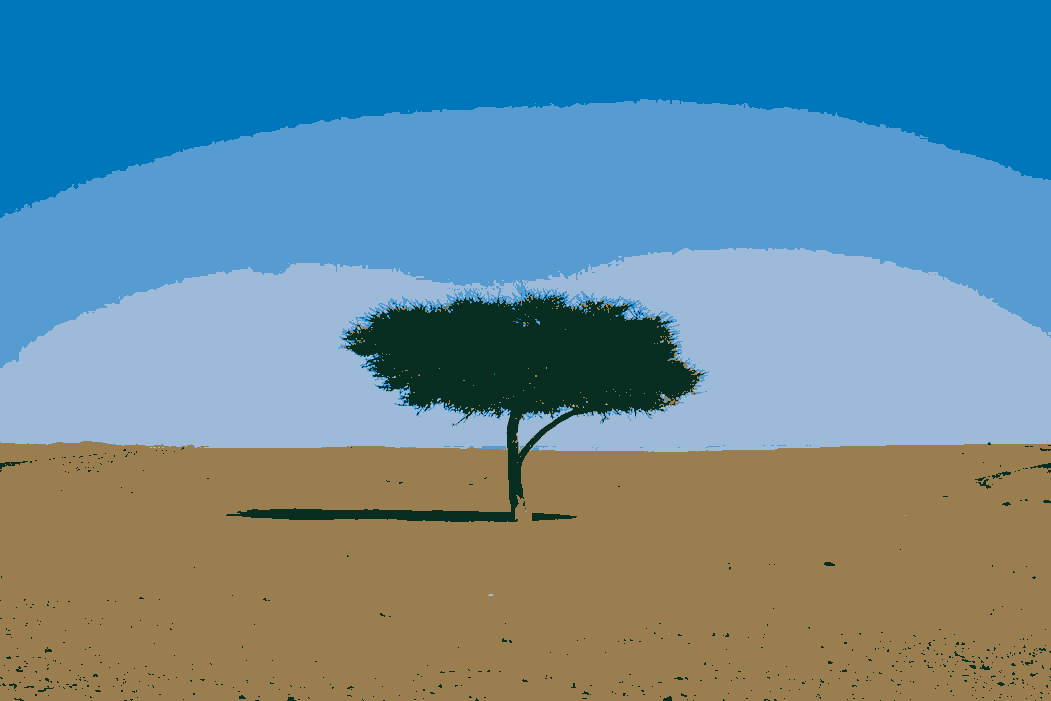

In [27]:
reconstruct_image(img_stack, labels, width, height)

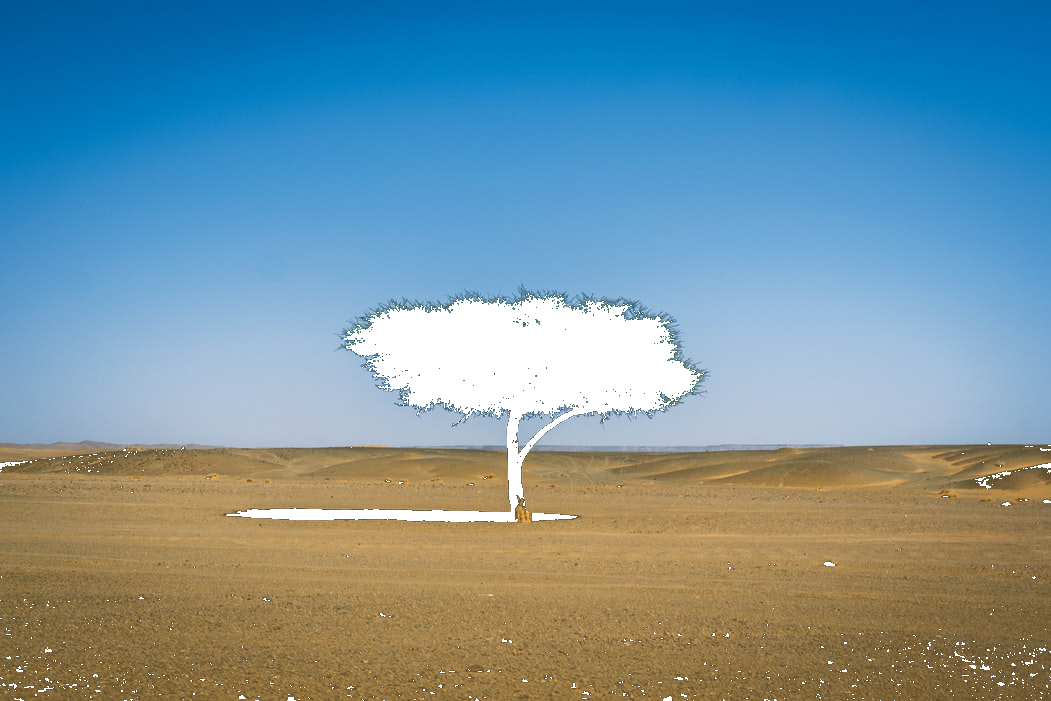

In [17]:
result = reconstruct_image(img_stack, labels, width, height, keep_labels=[0,1,2,3])
result

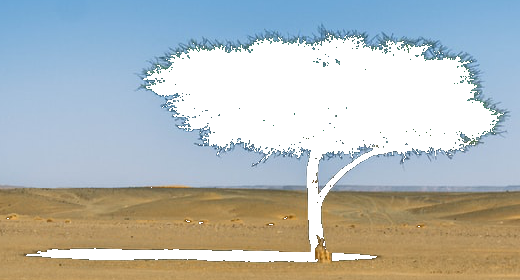

In [18]:
result_array = np.array(result)
cropped_array = result_array[260:540,200:720,:]
Image.fromarray(cropped_array)

In [19]:
dilation_mask = np.zeros(result_array.shape[0:2])
dilation_mask[260:540,200:720] = 1

In [20]:
from scipy import ndimage

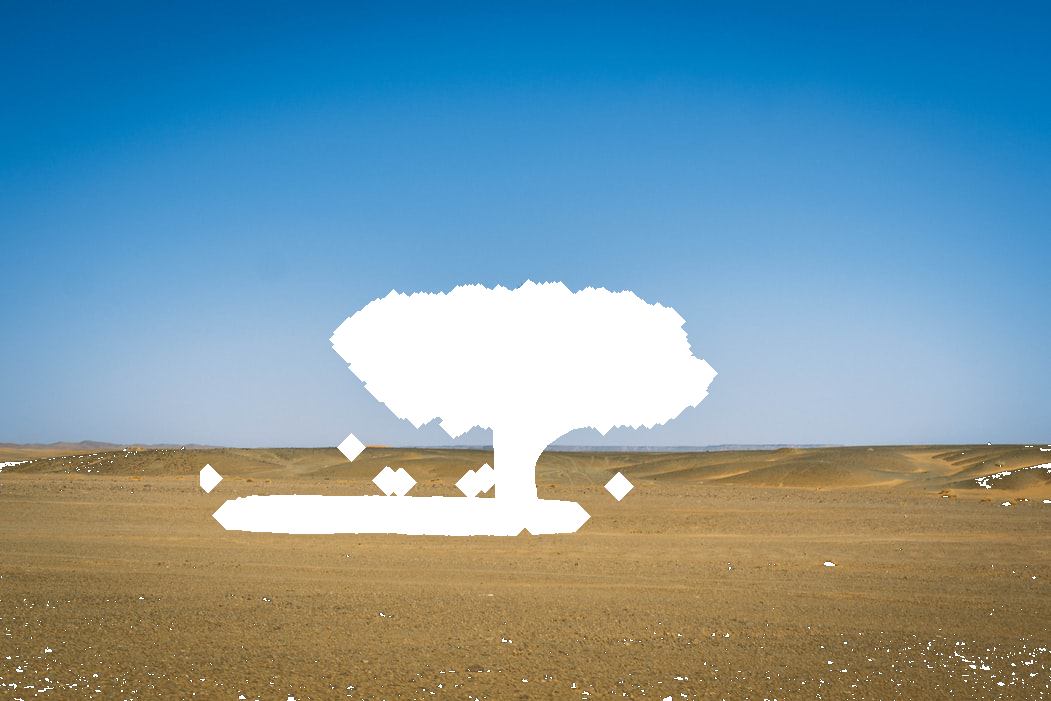

In [21]:
width, height = result.size
labels_array = labels.reshape((height, width))
binary_mask = 1*(labels_array == 4)
dilated_mask = ndimage.binary_dilation(binary_mask, iterations=14, mask=dilation_mask)
new_labels = dilated_mask.reshape((-1,))
dilated_result = reconstruct_image(img_stack, new_labels, width, height, keep_labels=[0])
dilated_result

In [22]:
np.median(result_array[h-1:h,get_range(w, width),:], axis=1).ravel()

NameError: ignored

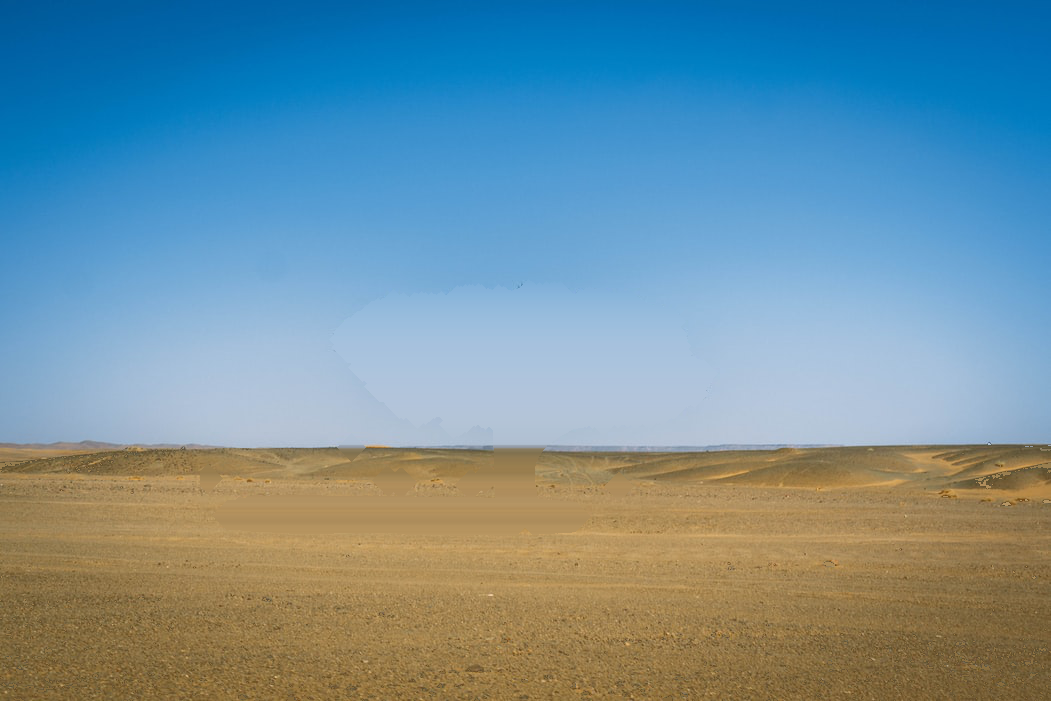

In [23]:
result_array = np.array(dilated_result)
height, width, _ = result_array.shape
for h in range(height):
  for w in range(width):
    if (result_array[h,w,:] == np.array([255, 255, 255])).all():
      result_array[h,w,:] = np.median(result_array[h,:,:], axis=0)
Image.fromarray(result_array)

In [24]:
def get_range(current_width, max_width, neighbours=100):
  half_neighbours = int(neighbours/2)
  if current_width < half_neighbours:
    return slice(0, neighbours)
  elif current_width > max_width - (half_neighbours):
    return slice(max_width-neighbours, max_width)
  else:
    return slice(current_width-half_neighbours, current_width + half_neighbours)

In [25]:
result_array = np.array(result)
height, width, _ = result_array.shape
for h in range(height):
  for w in range(width):
    if (result_array[h,w,:] == np.array([255, 255, 255])).all():
      result_array[h,w,:] = np.median(result_array[h-1:h,get_range(w, width),:], axis=0)
Image.fromarray(result_array)

ValueError: ignored

Color Compression

Another application of clustering on image data is to perform color quantization. This helps us compress image data by selecting a number of colors to be kept in the image. By reducing the total number of colors in an image, it's possible to compress it more inteligently, which reduces storage space.

To do that, we need to set the number of clusters of the KMeans algorithm as the number of colors we'd like to keep in the image. 

In [ ]:
quantization_model = KMeans(n_clusters=50)
quantization_model.fit(img_stack)
quantization_labels = quantization_model.labels_
quantization_centers = quantization_model.cluster_centers_

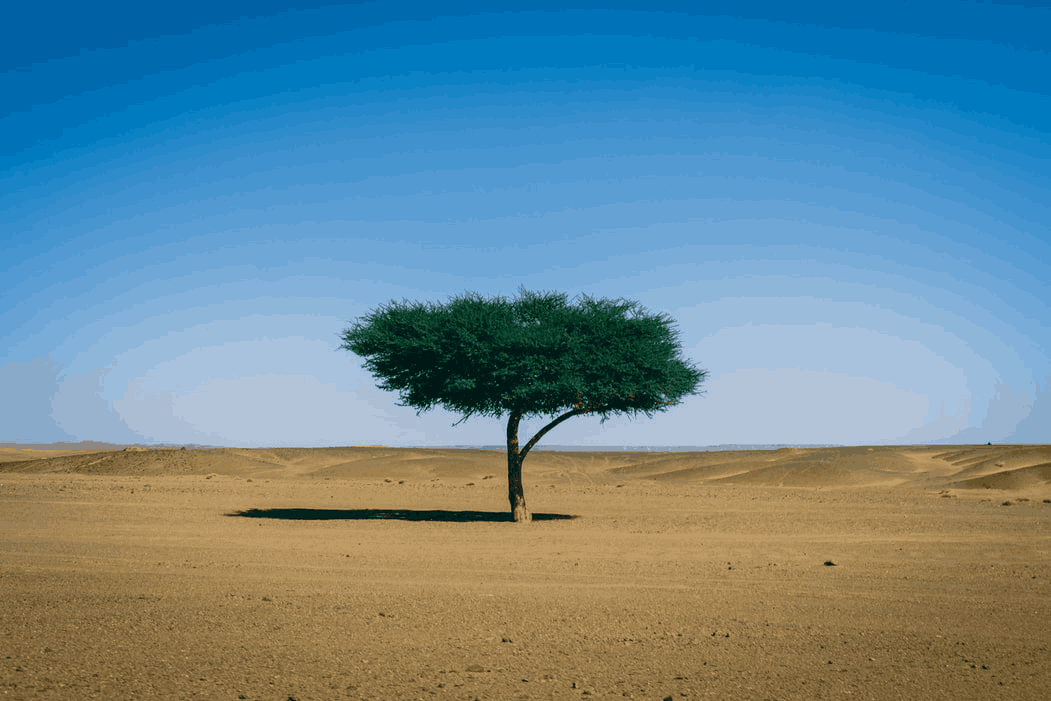

In [ ]:
reconstruct_image(img_stack, quantization_labels, width, height)

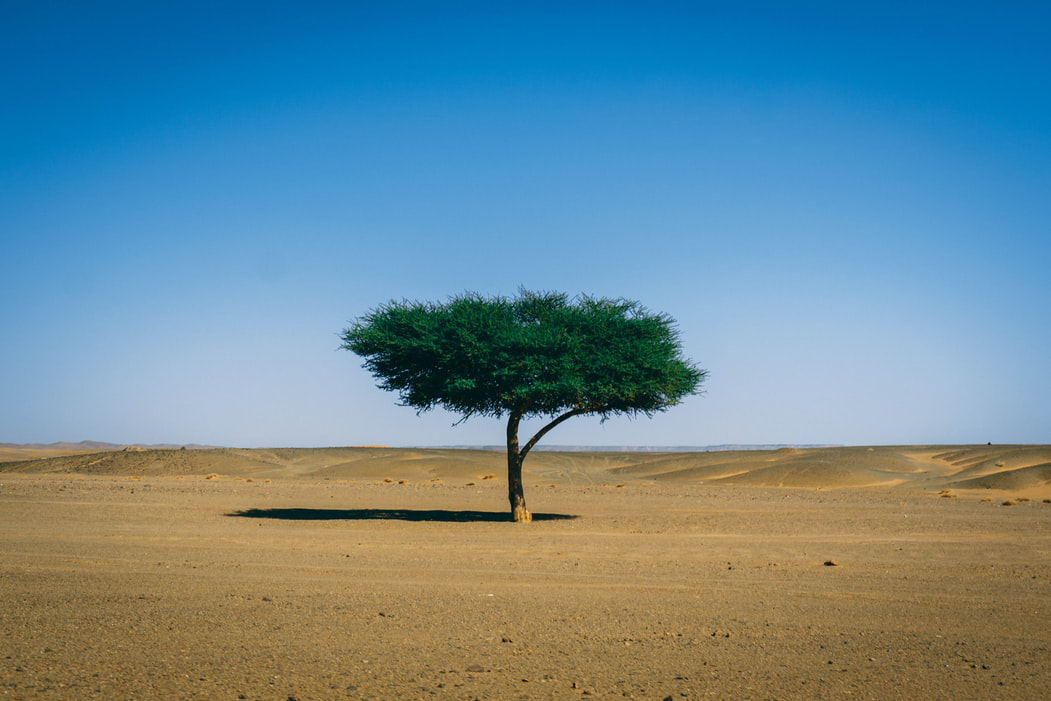

In [ ]:
img